# Handwritten Document Conversion

July 19, 2024

## Problem Statement


In today's digital age, vast amounts of information are stored in handwritten documents, ranging from historical manuscripts and personal notes to medical records and legal documents. While digitization has preserved these valuable texts, their handwritten nature poses a significant challenge for accessibility and searchability. Unlike typed text, handwritten content is often difficult to search, analyze, and utilize efficiently. This limitation hinders researchers, professionals, and the general public from extracting meaningful information and insights from these documents.

The project aims to address this challenge by developing a robust solution for converting digitized handwritten text into searchable text. By leveraging advanced techniques in machine learning and optical character recognition (OCR), this project seeks to create an automated system capable of accurately transcribing handwritten content. The goal is to enhance the usability of digitized handwritten documents, making them fully searchable and accessible, thereby unlocking their full potential for knowledge discovery and practical applications.

### Key objectives

1. Developing an accurate and efficient conversoin pipeline specifically tailored for handwritten text.
1. Ensuring high transcription accuracy across various styles of handwriting.
1. Creating a user-friendly interface for seamless integration and utilization of the transcribed text.
1. Addressing challenges related to the diversity and variability of handwriting.

> By successfully converting handwritten documents into searchable text, this project will facilitate easier access to valuable information, promote historical and academic research, and enhance the productivity of professionals who rely on handwritten records.

## Setup Env

In [1]:
!python --version

Python 3.11.8


### Import modules

In [2]:
import layoutparser as lp
import numpy as np
import pandas as pd
import cv2 as cv
import pathlib
import os
import requests
import copy
import pytesseract
from PIL import Image
from layoutparser.models.detectron2 import catalog
from matplotlib import pyplot as plt
from random import randrange

In [25]:
def load_model(config_path: str = 'lp://<dataset_name>/<model_name>/config', extra_config = None):
    config_path_split = config_path.split('/')
    dataset_name = config_path_split[-3]
    model_name = config_path_split[-2]

    # get the URLs from the MODEL_CATALOG and the CONFIG_CATALOG 
    # (global variables .../layoutparser/models/detectron2/catalog.py)
    model_url = catalog.MODEL_CATALOG[dataset_name][model_name]
    config_url = catalog.CONFIG_CATALOG[dataset_name][model_name]

    # override folder destination:
    if 'model' not in os.listdir():
        os.mkdir('model')

    config_file_path, model_file_path = None, None

    for url in [model_url, config_url]:
        filename = url.split('/')[-1].split('?')[0]
        save_to_path = f"model/" + filename
        if 'config' in filename:
            config_file_path = copy.deepcopy(save_to_path)
        if 'model_final' in filename:
            model_file_path = copy.deepcopy(save_to_path)

        # skip if file exist in path
        if filename in os.listdir("model"):
            continue
        # Download file from URL
        r = requests.get(url, stream=True, headers={'user-agent': 'Wget/1.16 (linux-gnu)'})

        with open(save_to_path, "wb") as f:
            for chunk in r.iter_content(chunk_size=4096):
                if chunk:
                    f.write(chunk)

    # load the label map
    label_map = catalog.LABEL_MAP_CATALOG[dataset_name]

    return lp.models.Detectron2LayoutModel(
        config_path=config_file_path,
        model_path=model_file_path,
        label_map=label_map,
        extra_config=extra_config
    )

### Import dset

Dataset description.

In [4]:
dset=pathlib.Path.home().joinpath('projects/Handwritten-Document-Conversion/data')
test=dset.joinpath('test')
test

PosixPath('/home/nikin/projects/Handwritten-Document-Conversion/data/test')

In [5]:
images=[cv.imread(test.joinpath(img).as_posix()) for img in test.iterdir()]

## Modeling

> [Layout Parser Model Zoo](https://layout-parser.readthedocs.io/en/latest/notes/modelzoo.html)

Since we are aiming for handwritten document conversion we will implement the models trained on 
the HJDataset. 

In [38]:
def parseLayout(image, model_path, extra_config=None):
    model = load_model(config_path=model_path, extra_config=extra_config)
    layout=model.detect(image)
    output = lp.visualization.draw_box(canvas=image, layout=layout,
                                       box_width=3, show_element_type=True,
                                       id_text_background_color='yellow')
    output.save("./layout.png")
    plt.figure(figsize=(20,20))
    plt.imshow(output)
    plt.axis('off')
    return layout

In [56]:
## Specify the pretrained model's path
model_path = 'lp://HJDataset/mask_rcnn_R_50_FPN_3x/config'

## Specify an image whose layout is to be parsed
randIndex = randrange(0, len(images)); print(randIndex)
img = images[randIndex]

113


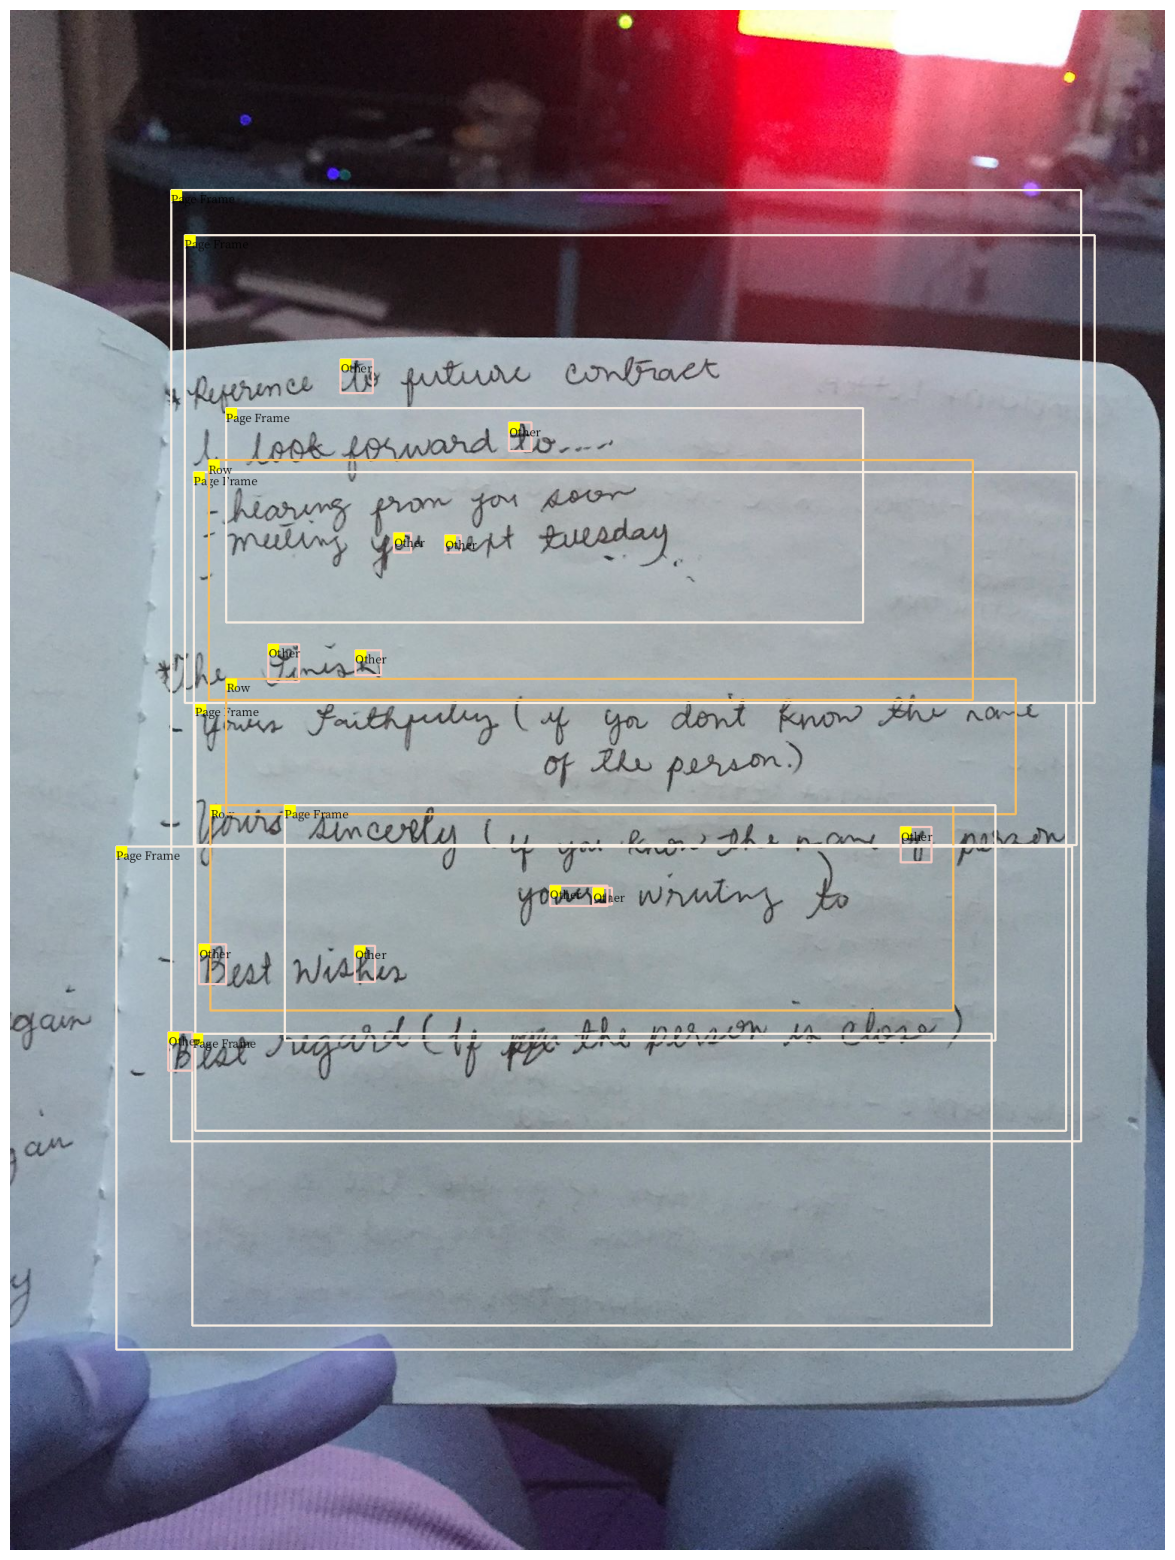

In [57]:
layout = parseLayout(img, model_path, ["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.5])

'Yowa Jibip ol TG O O\nBt Wk\nst g Ay g P pasr i eln)\n'

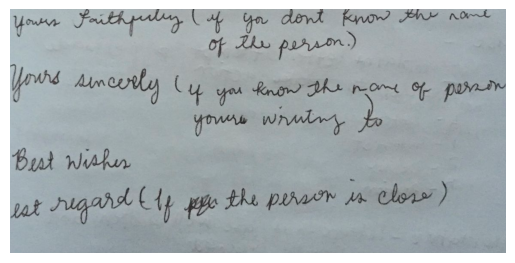

In [59]:
text_blocks = [b for b in layout]
text_block = text_blocks[0]
left = text_block.block.x_1
top = text_block.block.y_1
right = text_block.block.x_2
bottom = text_block.block.y_2
left, top, right, bottom = map(int, [left, top, right, bottom])
cropped_image = img[top:bottom, left:right]
plt.imshow(cropped_image)
plt.axis('off')
cropped_image_rgb = cv.cvtColor(cropped_image, cv.COLOR_BGR2RGB)
cropped_image_pil = Image.fromarray(cropped_image_rgb)
extracted_text = pytesseract.image_to_string(cropped_image_pil)
extracted_text

In [13]:
text = lp.visualization.draw_text(canvas=img, layout=layout)
text.save("./text.png")

plt.figure(figsize=(20,20))
plt.imshow(text)
plt.axis('off')

TypeError: argument of type 'NoneType' is not iterable

## Performance